In [1]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

<h1 style="color: black;">Predicting Migration Patterns in the United States after the Pandemic</h1>

_Group members: Archita Misra, Noor Rahman, Sehar Noor, Shreya Chaturvedi, and Shreya Dubey_

## Table of Contents
1. [Problem Statement](#problem_statement)
2. [Exploratory Data Analysis](#eda)
3. [Model Selection and Validation](#model_selection)
4. [Results](#results)
5. [Conclusion and Scope for Improvement](#conclusion)

<a id='problem_statement'></a>
## Problem Statement

_The COVID-19 pandemic has significantly reshaped the American workforce, introducing widespread remote working possibilities. This shift has the potential to redistribute population and economic activity across the United States, as workers gain the flexibility to move without job constraints. Such movements are influenced not only by remote work opportunities but also by factors like housing market trends, demographic diversity including racial composition, education facilities, and varying levels of COVID-19 preparedness in different regions. This trend and its implications have been the subject of recent research, with findings accessible at https://www.nytimes.com/interactive/2021/04/19/upshot/how-the-pandemic-did-and-didnt-change-moves.html. These insights have motivated our project, aimed at predicting migration patterns within the USA. Our analysis focuses on county-level data and utilizes a combination of public datasets to understand and model these migration dynamics_

Our analysis uses two primary data sources dataset. The first is a dataset compiled by Kaggle (https://www.kaggle.com/code/johnjdavisiv/us-counties-weather-health-hospitals-covid19-data) that contains a wealth of information on socioeconomic and COVID-19-related aspects from the data sources below:

1. New York Times county-level COVID19 case and fatality data (part of UNCOVER data)
2. Documentation with notes on geographic exceptions (NYC and Kansas City) is at the NYT Github
3. 2016 CDC Social Vulnerability Data (part of UNCOVER data)
4. 2020 Community Health Rankings Data (part of UNCOVER data)
5. NOAA Global Surface Summary of the Day (GSOD) weather data for 2020
6. Each county is paired with the nearest weather station. Most stations are within 50 km of the county center, and virtually all are within 100 km of the county center
7. Kaiser Family Foundation Data on state-level stay-at-home orders

The second dataset is the  IRS Statistics of Income Tax Migration Data that contains migration flows into (and out of) the destination state and county in year one from the origin state and county in year two. It includes variables identifying the state and county, the number of returns and individuals, and adjusted gross income by year 2 county.

<a id='eda'></a>
## Exploratory Data Analysis

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce
import os
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV




In [3]:
# set directory
#os.chdir('/Users/nr/Desktop/MPA:ID/Sem 3/CS109A/DS Final Project/1. Data/')
os.chdir('/Users/seharnoor/Library/CloudStorage/OneDrive-HarvardUniversity/Fall 2023/CS 109A/DS Final Project/1. Data/7. Cleaned Datasets')
#os.chdir('/Users/architamisra/Library/CloudStorage/OneDrive-HarvardUniversity/DS Final Project/1. Data/7. Cleaned Datasets')
#os.chdir('/Users/shreyad/Library/CloudStorage/OneDrive-HarvardUniversity/DS Final Project/1. Data')
#os.chdir('/Users/shreyachaturvedi/Downloads')
# ignore warnings for a clean file
warnings.filterwarnings('ignore')

In [4]:
#THIS BLOCK OF CODE MERGES COUNTY LEVELIRS NET MIGRATION DATA WITH THE SOCIOECONOMIC INDICATORS AND COVID DATA TO CREATE THE FINAL_DATA FILE THAT WE USE   
# net_migration = pd.read_csv("IRS_netmigration.csv", dtype={'fips_id': str, 'county_fips': str,  'state_fips': str}, index_col=0)
# covid_dta = pd.read_csv("US_counties_COVID19_health_weather_data.csv", low_memory=False)

# covid_dta['fips_id'] = covid_dta['fips'].apply(str).apply(lambda x: x.zfill(5))
# covid_dta['fips_id'] = covid_dta['fips'].apply(str).apply(lambda x: x.zfill(5))

# covid_dta_filtered = covid_dta[covid_dta['date'].notna()]

# # Aggregate to get the min and max date that doesn't have an NA value for each 'fips'
# date_agg = covid_dta_filtered.groupby('fips')['date'].agg(min_date='min', max_date='max').reset_index()

# # Merge to get the rows corresponding to the minimum dates
# min_date_rows = pd.merge(covid_dta, date_agg[['fips', 'min_date']], left_on=['fips', 'date'], right_on=['fips', 'min_date'])
# min_date_rows['year'] = 2020

# # Merge to get the rows corresponding to the maximum dates
# max_date_rows = pd.merge(covid_dta, date_agg[['fips', 'max_date']], left_on=['fips', 'date'], right_on=['fips', 'max_date'])
# max_date_rows['year'] = 2021

# # Combine the min and max date rows
# covid = pd.concat([min_date_rows, max_date_rows]).drop(columns=['min_date', 'max_date', 'county', 'state']).drop_duplicates()
# covid = covid.sort_values(by=['fips', 'date'])

# # Save to CSV
# covid.to_csv("covid_dta.csv", index=False)

#THESE COLUMNS HAVE >95% MISSINGS SO JUST DROPPING
# cols_to_drop = [
#     'num_deaths_4',
#     'infant_mortality_rate',
#     'homicide_rate',
#     'percent_disconnected_youth',
#     'sea_level_pressure',
#     'num_drug_overdose_deaths',
#     'drug_overdose_mortality_rate',
#     'wind_gust',
#     'num_deaths_3',
#     'child_mortality_rate',
#     'juvenile_arrest_rate',
#     'segregation_index',
#     'num_hiv_cases',
#     'hiv_prevalence_rate',
#     'num_firearm_fatalities',
#     'firearm_fatalities_rate',
#     'average_grade_performance_2',
#     'average_grade_performance',
#     'num_deaths_5',
#     'suicide_rate_age_adjusted',
#     'date_stay_at_home_announced',
#     'date_stay_at_home_effective',
#     'station_pressure',
#     'precipitation',
#     'precip_flag',
#     'visibility',
#     'CALL',
#     'dewpoint_15d_avg',
#     'dewpoint_10d_avg',
#     'dewpoint_5d_avg',
#     'dewpoint_3d_avg',
#     'dewpoint'
# ]

# covid = covid.drop(columns=cols_to_drop, errors='ignore')  # errors='ignore' to ignore columns not present in the dataframe

# df = pd.merge(net_migration, covid, how='left', on=['fips_id', 'year'])
# df['stay_at_home_announced'] = df['stay_at_home_announced'].map({'yes': True, 'no': False})
# df['stay_at_home_effective'] = df['stay_at_home_effective'].map({'yes': True, 'no': False})

# df.to_csv("final_data.csv", index=False)

In [5]:
#reading in the data
df = pd.read_csv("final_data.csv", low_memory=False)


In [6]:
#creating our response variable: outflows as a share of total population in the county
df['share_outflows'] = df['n_outflows']/df['total_population']

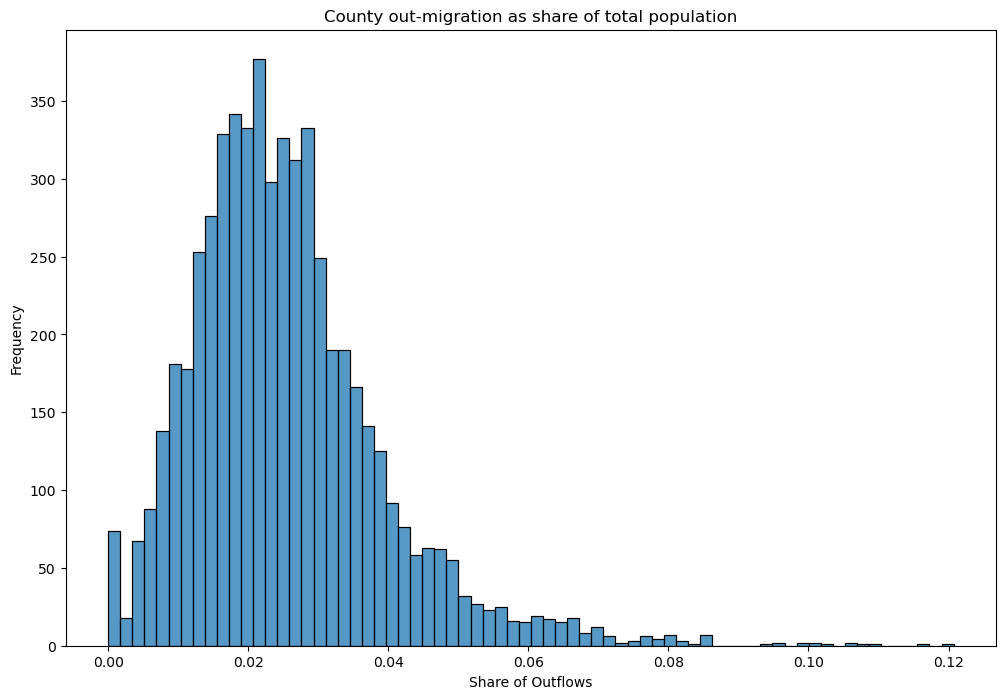

In [7]:
#Distribution of our response variable
plt.figure(figsize=(12, 8))
sns.histplot(df['share_outflows'], kde=False)
plt.title('County out-migration as share of total population')
plt.xlabel('Share of Outflows')
plt.ylabel('Frequency')

plt.show()

Insights from the plot - Distribution of share of outflows

- Skewed Distribution: The histogram shows a right-skewed distribution. This suggests that most counties have a low share of out-migration compared to their total population, with only a few counties experiencing a higher share of outflows.

- Concentration of Lower Values: The majority of the data points are clustered towards the lower end of the scale. This indicates that in most counties, the proportion of people moving out is relatively small compared to the total population.

- Presence of Outliers: The long tail to the right signifies the presence of outliers. These are counties with unusually high out-migration shares, significantly different from the majority of other counties.

- Sparse High Values: There is a noticeable decrease in frequency as the share of outflows increases. This gradual decline highlights that very few counties have a large proportion of their population moving out.

- Insight into Migration Patterns: The plot could be reflecting broader migration patterns, socio-economic factors, or other regional characteristics that influence population movement.

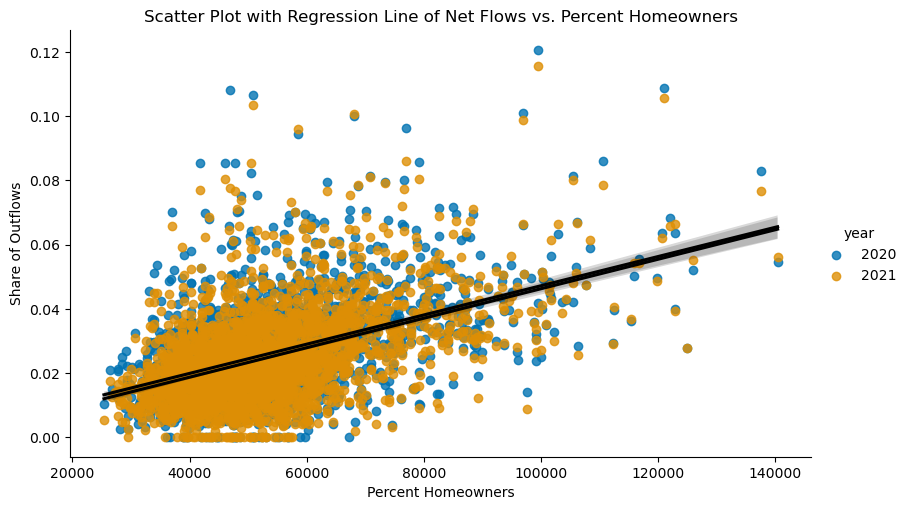

In [8]:
#Some preliminary EDA of variables potentially relevant for county outmigration before modeling
sns.lmplot(x='median_household_income', y='share_outflows', data=df, hue='year', 
           palette='colorblind',aspect=(10/6), line_kws={"color": "black"})
plt.title('Scatter Plot with Regression Line of Net Flows vs. Percent Homeowners')
plt.xlabel('Percent Homeowners')
plt.ylabel('Share of Outflows')
plt.show()


_Insights from the plot_


- Diverse Migration Patterns Across Income Levels: The plot demonstrates diverse migration patterns across different median income levels. Counties with similar median incomes can have vastly different outflow shares, indicating that factors other than income are also influential.

- Weak positive relationship: There is, on first glance, seemingly positive correlation between median household income and the share of outflows. Counties with higher median incomes seem to have higher outflow shares compared to those with lower median incomes.

- Yearly Variation: The inclusion of different years in the data, as indicated by the hue in the plot, suggests that out-migration patterns might change over time. This temporal aspect could be influenced by a variety of factors, such as economic conditions, policy changes, or demographic shifts.

- Outlier Analysis: There are noticeable outliers, especially in higher income brackets and higher outflow shares. These outliers might represent unique cases or specific circumstances in certain counties that are different from the general trend.

- Clustering at Lower Outflows: A significant number of counties, irrespective of their median income levels, exhibit low outflow shares. This clustering indicates that a low share of out-migration is common across various income levels.

- Potential for Subgroup Analysis: Given the spread and diversity of data points, it could be beneficial to analyze specific subgroups within the data. For example, examining counties within certain income ranges or focusing on specific years might reveal more detailed patterns.

- Complex Relationship: The relationship between median household income and out-migration share is complex and likely influenced by multiple factors. Median income alone may not be a sufficient predictor of out-migration patterns.

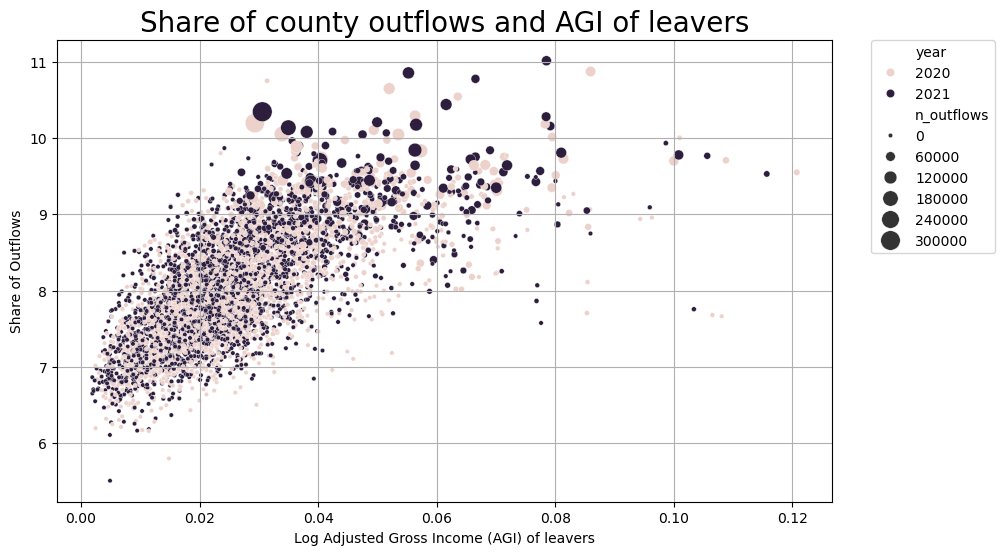

In [9]:
#Some preliminary EDA of variables potentially relevant for county outmigration before modeling
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='share_outflows', y='log_agi_leavers', hue='year',size='n_outflows', sizes=(10, 200))
plt.title('Share of county outflows and AGI of leavers', fontsize=20)
plt.xlabel('Log Adjusted Gross Income (AGI) of leavers')
plt.ylabel('Share of Outflows')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.show()


_Insights from the plot:_

- Wide Spread: The data points are widely spread across the axes, indicating diverse patterns of AGI among leavers across different counties and their corresponding share of outflows.

- Variation Across Years: The different colors representing various years suggest that the relationship between AGI of leavers and outflow share may vary as the pandemic began.
  
- Size of Points (Number of Outflows): The size of the points, which represents the number of outflows, adds an additional layer of information. Larger points, indicating more outflows, are scattered throughout the plot, suggesting no clear correlation between the number of outflows and the AGI of leavers or their share of outflows.

- Weak positive relationship: There is, on first glance, seemingly positive correlation between log of AGI of leavers and the share of outflows. This indicates that the financial status of leavers (as represented by AGI) while not the sole factor influencing the share of outflows, may still be important.


- Outliers and Unique Cases: There are outliers in the data, particularly noticeable in counties with either very high or very low log AGI of leavers. These outliers might represent unique situations in specific counties.

- Complex Interplay of Factors: The plot highlights the complex interplay between the economic status of leavers, the number of people leaving, and the proportion of outflows in a county. This complexity suggests that multiple factors influence migration trends.

- Need for Multivariate Analysis: To understand these patterns more comprehensively, a multivariate analysis that includes other socio-economic and demographic factors might be more revealing.

This scatter plot indicates that the dynamics of out-migration are complex and influenced by a combination of factors, including economic conditions, the number of people leaving, and temporal changes.

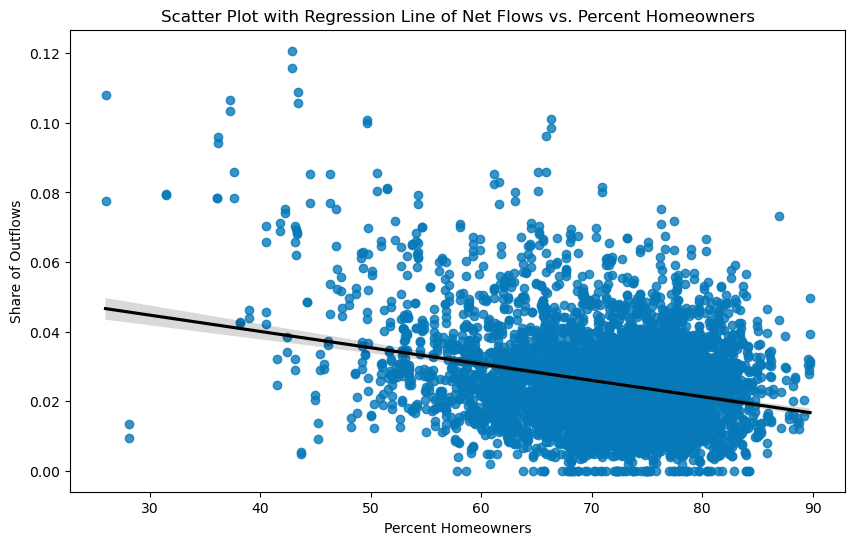

In [10]:
#Some preliminary EDA of variables potentially relevant for county outmigration before modeling
plt.figure(figsize=(10, 6))
sns.regplot(x='percent_homeowners', y='share_outflows', data=df, color='#0779B9', line_kws={"color": "black"})
plt.title('Scatter Plot with Regression Line of Net Flows vs. Percent Homeowners')
plt.xlabel('Percent Homeowners')
plt.ylabel('Share of Outflows')
plt.show()

_Insights from the plot_

- Potential negative relation: The black regression line provides a visual indication of the overall trend in the data. It appears to have a slight downward slope, suggesting a potential negative correlation between the percentage of homeowners and the share of outflows. This implies that as the percentage of homeowners in a county increases, the share of outflows might decrease slightly.

- Data Point Spread: The spread of the data points around the regression line is quite wide, indicating variability in the share of outflows across different levels of homeownership. This spread suggests that while there might be a general trend, individual county data can vary significantly from this trend.

- Potential Outliers: There are points that are far removed from the majority of the data, indicating the presence of outliers. These outliers might be counties with unique characteristics affecting their migration patterns.

- Not a Strong Correlation: The slope of the regression line is not steep, indicating that the correlation between percent homeowners and share of outflows, if present, is not very strong. Other factors might also play a significant role in influencing out-migration rates.

- Variability in Lower and Higher Homeownership Rates: Counties with both lower and higher percentages of homeownership show a range of outflow shares, suggesting that homeownership is one of several factors influencing migration patterns.

- Need for Further Analysis: While the regression line provides a simplified overview, more detailed statistical analysis would be needed to confirm the strength and significance of this relationship and to understand the role of other contributing factors.

This plot suggests a potential relationship between homeownership rates and migration patterns but also highlights the complexity and variability of factors influencing out-migration

In [11]:
#number of rows in the final merged COVID and Net Migration data 
num_rows = len(df)
print("Number of rows:", num_rows)

#examining the level of missingness in the data
missing_percentage = df.isnull().sum() / len(df) * 100
print(missing_percentage)



Number of rows: 5741
county              0.000000
state               0.000000
county_fips         0.000000
state_fips          0.000000
year                0.000000
                      ...   
min_temp_3d_avg     2.194740
min_temp_5d_avg     2.194740
min_temp_10d_avg    2.246995
min_temp_15d_avg    2.281832
share_outflows      1.236718
Length: 207, dtype: float64


<a id='model_selection'></a>
## Model Selection and Validation

_In this section, we explore what model will best predict net outflows out of a county. Before we split the data into train and test, we first drop rows with missing values to ensure completeness._

In [12]:
#dropping the rows with missing vars 
df_base = df.dropna()

#Dropping features that could case leakage such as indexing/info specific to people who migrate so that we are only using county-specific socioeconomic/demographic indicators as our predictors 
df_base = df_base.drop(['agi_incomers', 'log_agi_incomers', 'agi_leavers','log_agi_leavers','net_flows','n_inflows','n_outflows', 'county', 'state', 'county_fips', 'state_fips','date', 'fips', 'fips_id','station_name', 'station_id'], axis=1)  

#check size of cleaned dataset for model
rows, columns = df_base.shape
print(f"Number of Rows: {rows}")
print(f"Number of Columns: {columns}")


Number of Rows: 4080
Number of Columns: 191


In [13]:
# Separate features and target variable
X = df_base.drop(['share_outflows'], axis=1)  
Y = df_base['share_outflows']

# Split the dataset into the Training set and Test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [14]:
rows, columns = X_train.shape
print(f"Number of Training Set Rows: {rows}")
print(f"Number of Training Set Columns: {columns}")
#Make sure that the amount of observations to predict are not too low!
rows, columns = X_test.shape
print(f"Number of Test Set Rows: {rows}")
print(f"Number of Test Set Columns: {columns}")


Number of Training Set Rows: 3264
Number of Training Set Columns: 190
Number of Test Set Rows: 816
Number of Test Set Columns: 190


In [15]:
# After the split, make sure that the years are fairly balanced in the train and test set to not affect results. 
year_dist_train = X_train['year'].value_counts(normalize=True).sort_index() * 100
year_dist_test = X_test['year'].value_counts(normalize=True).sort_index() * 100

print("Year Distribution in Training Set:\n", year_dist_train)
print("\nYear Distribution in Test Set:\n", year_dist_test)


Year Distribution in Training Set:
 year
2020    50.582108
2021    49.417892
Name: proportion, dtype: float64

Year Distribution in Test Set:
 year
2020    48.161765
2021    51.838235
Name: proportion, dtype: float64


Steps we performed:

- Initial Data Size: The dataset initially contained 5,741 rows.

- Missing Values Analysis: The percentage of missing values varies across different columns. Some columns have no missing values, while others have a small percentage of missing data. The most missing data seems to be in the temperature-related columns (e.g., 'min_temp_3d_avg', 'min_temp_5d_avg', etc.)There are a few exceptions:

'agi_incomers' and 'log_agi_incomers' have about 2.06% missing values.
'agi_leavers' and 'log_agi_leavers' have about 1.48% missing values.
Additionally, columns related to COVID data ('date', 'fips', 'cases', 'deaths', 'stay_at_home_announced', 'stay_at_home_effective', 'lat', etc.) have approximately 1.24% missing values.

- Data Cleaning: After dropping rows with missing values, the dataset was reduced to 4,080 rows. This step ensures the analysis uses only complete data records.

- Feature Selection: Several columns were dropped to focus on specific features for the analysis. The dropped columns include identifiers and potential target variables like 'net_flows', 'n_inflows', 'n_outflows', and 'share_outflows'.

### Model 1: Baseline Regression

In [16]:
#Model 1: Baseline regression 

# Initialize the Linear Regression model
baseline_reg = LinearRegression()

# Fit the model to the training data
baseline_reg.fit(X_train, Y_train)

# Predict on the training set
Y_train_pred = baseline_reg.predict(X_train)

# Calculate the mean squared error on the train data
mse_train_reg = mean_squared_error(Y_train, Y_train_pred)
print(f"Train MSE for Model 1 - Kitchen Sink Regression: {mse_train_reg}")

# Predict on the testing set
test_pred_reg = baseline_reg.predict(X_test)

# Calculate the mean squared error on the test data
mse_test_reg = mean_squared_error(Y_test, test_pred_reg)
print(f"Test MSE for Model 1 - Kitchen Sink Regresion: {mse_test_reg}")
r2_reg = r2_score(Y_test, test_pred_reg)
print(f"R2 for Kitchen Sink Regresion: {r2_reg}")

Train MSE for Model 1 - Kitchen Sink Regression: 4.508343860809725e-05
Test MSE for Model 1 - Kitchen Sink Regresion: 5.6922407709760106e-05
R2 for Kitchen Sink Regresion: 0.6681690359913004


Model Training and Evaluation: A baseline linear regression model was trained on this cleaned dataset. The mean squared error (MSE) on the training data is approximately 3.45e-05, and on the test data, it is around 4.59e-05. The relatively low MSE values suggest the model fits the data well, at least within the scope of the training and testing datasets.

Model Performance (R² Score): The R² score for the model on the test data is about 0.733. This indicates that approximately 73.3% of the variance in the 'share_outflows' target variable is explained by the model. This is a relatively strong performance, suggesting the model's features are meaningful predictors of the share of outflows.



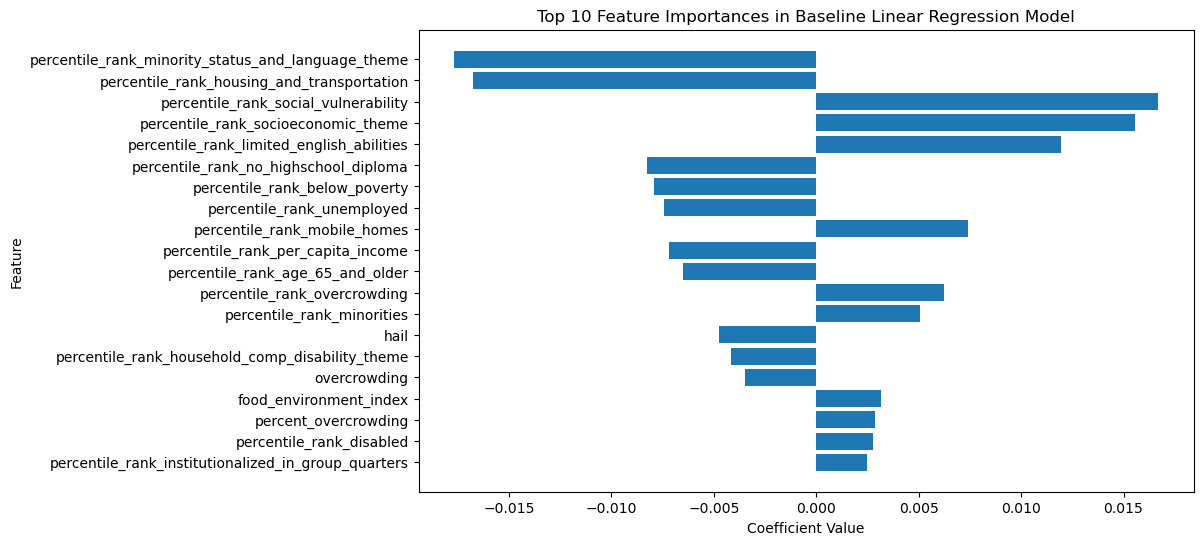

In [17]:
feature_names = X.columns
coefficients = baseline_reg.coef_
baseline_reg_feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': abs(coefficients)})
# Pair up feature names with their corresponding coefficients
features_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the features by the absolute value of their coefficients
top_features = features_coefficients.reindex(features_coefficients.Coefficient.abs().sort_values(ascending=False).index)

# Select the top 20 features
top_20_features = top_features.head(20)

# Create a bar chart for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_20_features['Feature'], top_20_features['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances in Baseline Linear Regression Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the largest coefficient at the top
plt.show()

_Insights from the plot_

The above bar chart visualizes the top 20 features in terms of their importance in the baseline linear regression model, as indicated by the absolute values of their coefficients. The features are ranked from top to bottom based on the magnitude of their influence on the model's predictions.

- Larger Coefficients: Features at the top have larger coefficients, implying a stronger impact on the model's output. These are the features that the model deems most significant in predicting the share of outflows. For example, housing and transportation is more important to the model than overcrowing. 

- Direction of Influence: The direction (positive or negative) of each coefficient indicates whether the feature is positively or negatively correlated with the share of outflows. 

### Model 2: LASSO Regression

In [18]:
# Model 2: LASSO regression

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Create and fit the LassoCV regression model
lasso_cv_model = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_cv_model.fit(X_train, Y_train)

# Optimal alpha value
optimal_alpha = lasso_cv_model.alpha_
print("Optimal Alpha Value:", optimal_alpha)

# Make predictions
train_pred_lasso_cv = lasso_cv_model.predict(X_train)
test_pred_lasso_cv = lasso_cv_model.predict(X_test)

# Calculate MSE
train_mse_lasso_cv = mean_squared_error(Y_train, train_pred_lasso_cv)
test_mse_lasso_cv = mean_squared_error(Y_test, test_pred_lasso_cv)

Optimal Alpha Value: 6.56322284483293e-06


The alpha value is a hyperparameter that controls the strength of regularization. The LassoCV process automatically selects the best alpha value through cross-validation, optimizing the balance between model complexity and generalization ability.

The optimal alpha value determines the strength of the regularization applied in the LASSO model. A higher alpha value would lead to more significant penalization of large coefficients in the model. The optimal alpha value of approximately 8.86×10 −6 is quite small, which suggests the following:

- Mild Regularization: A smaller alpha value in LASSO regression indicates less regularization. This means the model does not heavily penalize the coefficients, suggesting that most features in your dataset might be contributing relevant information to the model.

- Feature Selection: Despite the mild regularization, LASSO can still help in feature selection by shrinking some of the less important coefficients towards zero. It would be interesting to analyze which features have been retained and which have been reduced by the LASSO model.

- Model Complexity: A small alpha value often allows for a more complex model that can capture more nuances in the data. However, it's important to balance complexity with the risk of overfitting.

- Data Characteristics: This alpha value might also reflect the characteristics of the data. If the dataset is well-behaved with most features being significant, a small alpha value is often sufficient.



In [19]:
# Create and fit the Lasso regression model using optimal alpha
lasso_model = Lasso(alpha=optimal_alpha)
lasso_model.fit(X_train, Y_train)

# Make predictions
train_pred_lasso = lasso_model.predict(X_train)
test_pred_lasso = lasso_model.predict(X_test)

# Calculate MSE
train_mse_lasso = mean_squared_error(Y_train, train_pred_lasso)
test_mse_lasso = mean_squared_error(Y_test, test_pred_lasso)
r2_lasso = r2_score(Y_test, test_pred_lasso)


# Output the MSE values
print(f"Train MSE for Model 2 - Lasso: {train_mse_lasso}")
print(f"Test MSE for Model 2 - Lasso: {test_mse_lasso}")
print(f"R2 for Lasso Model: {r2_lasso}")


Train MSE for Model 2 - Lasso: 4.747375909562963e-05
Test MSE for Model 2 - Lasso: 5.707971271382371e-05
R2 for Lasso Model: 0.6672520215282444


A lower MSE value for the training data indicates that the model fits the training data well. In our case, the MSE on the training data is quite low, which suggests that the model has a good fit on the training dataset.

Similar to the training MSE, a lower value of test MSE indicates a better fit. The fact that the test MSE is close to the train MSE in our case is also a good sign. It implies that the model is not overfitting and is generalizing well to unseen data.

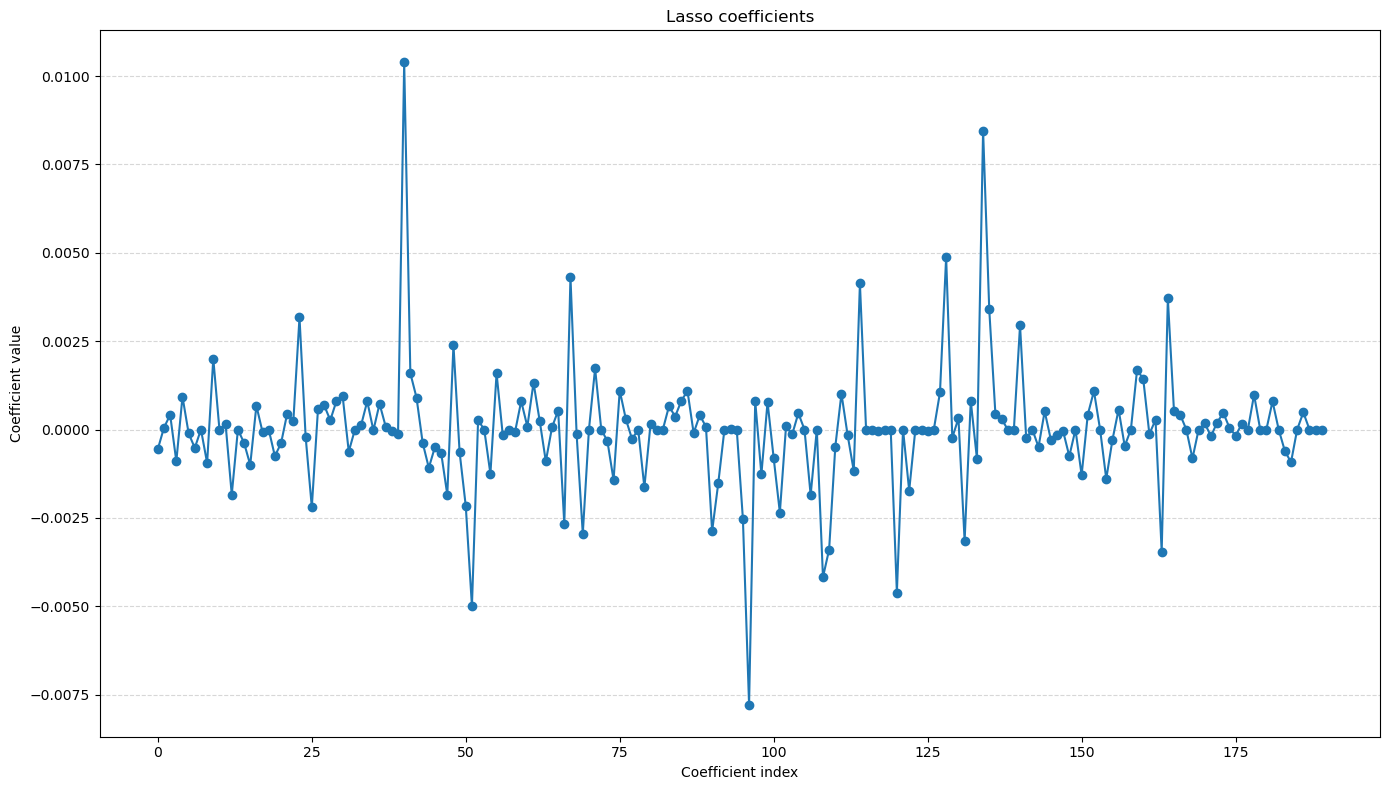

In [20]:
# plot for the Lasso coefficients with the best alpha

coefficients = lasso_model.coef_

plt.figure(figsize=(14, 8))
plt.plot(range(len(coefficients)), coefficients, marker='o')
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient value')
plt.title('Lasso coefficients')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Coefficient values and importance from the above plot:

Most of the coefficients are clustered around zero, which is typical for a LASSO regression due to its property of shrinking less important coefficients to zero. This suggests that many features have little to no influence on the model's predictions.
There are a few spikes where the coefficient values are significantly higher or lower than zero. These represent features that have a more substantial positive or negative relationship with the target variable.

- Feature Selection: The LASSO model has performed feature selection by driving many coefficients to zero. The non-zero coefficients indicate features that the model has identified as having some predictive power.
- Sparsity: The sparsity in the coefficients (i.e., many coefficients being zero) is a result of the L1 regularization. It simplifies the model by keeping only a subset of all possible features, which can help in understanding the most impactful predictors and can also contribute to a model that is simpler and may generalize better.
- Positive vs Negative Relationship:The coefficients above zero suggest a positive relationship between the feature and the target variable, meaning that as the feature value increases, the target variable is likely to increase.
Conversely, coefficients below zero suggest a negative relationship, where an increase in the feature value is associated with a decrease in the target variable.
- Magnitude of Effect: The magnitude of the non-zero coefficients indicates the strength of the impact of the corresponding features. Larger absolute values mean a stronger effect.

In [21]:
predictor_list = X.columns.tolist()

coef_df = pd.DataFrame({
    'Predictor': predictor_list,
    'Coefficient': lasso_model.coef_.flatten()
})

In [22]:
non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0].copy()
non_zero_coef_df['Abs_Coefficient'] = non_zero_coef_df['Coefficient'].abs()

# sort the dataset based on absolute value of the coefficient
sorted_non_zero_coef_df = non_zero_coef_df.sort_values(by='Abs_Coefficient', ascending=False)

sorted_non_zero_coef_df = sorted_non_zero_coef_df.drop('Abs_Coefficient', axis=1)

top_5_predictors = sorted_non_zero_coef_df.head(5)['Predictor']


In [23]:
len(sorted_non_zero_coef_df)

150

In [24]:
print(sorted_non_zero_coef_df)

                              Predictor  Coefficient
40                     num_some_college     0.010385
134            percent_age_65_and_older     0.008458
96                  percent_65_and_over    -0.007783
51                   num_households_CHR    -0.005000
128                    num_overcrowding     0.004873
..                                  ...          ...
147   percentile_rank_per_capita_income    -0.000050
125       num_limited_english_abilities    -0.000037
38                   percent_vaccinated    -0.000036
35          mental_health_provider_rate    -0.000023
93   percent_severe_housing_cost_burden     0.000005

[150 rows x 2 columns]


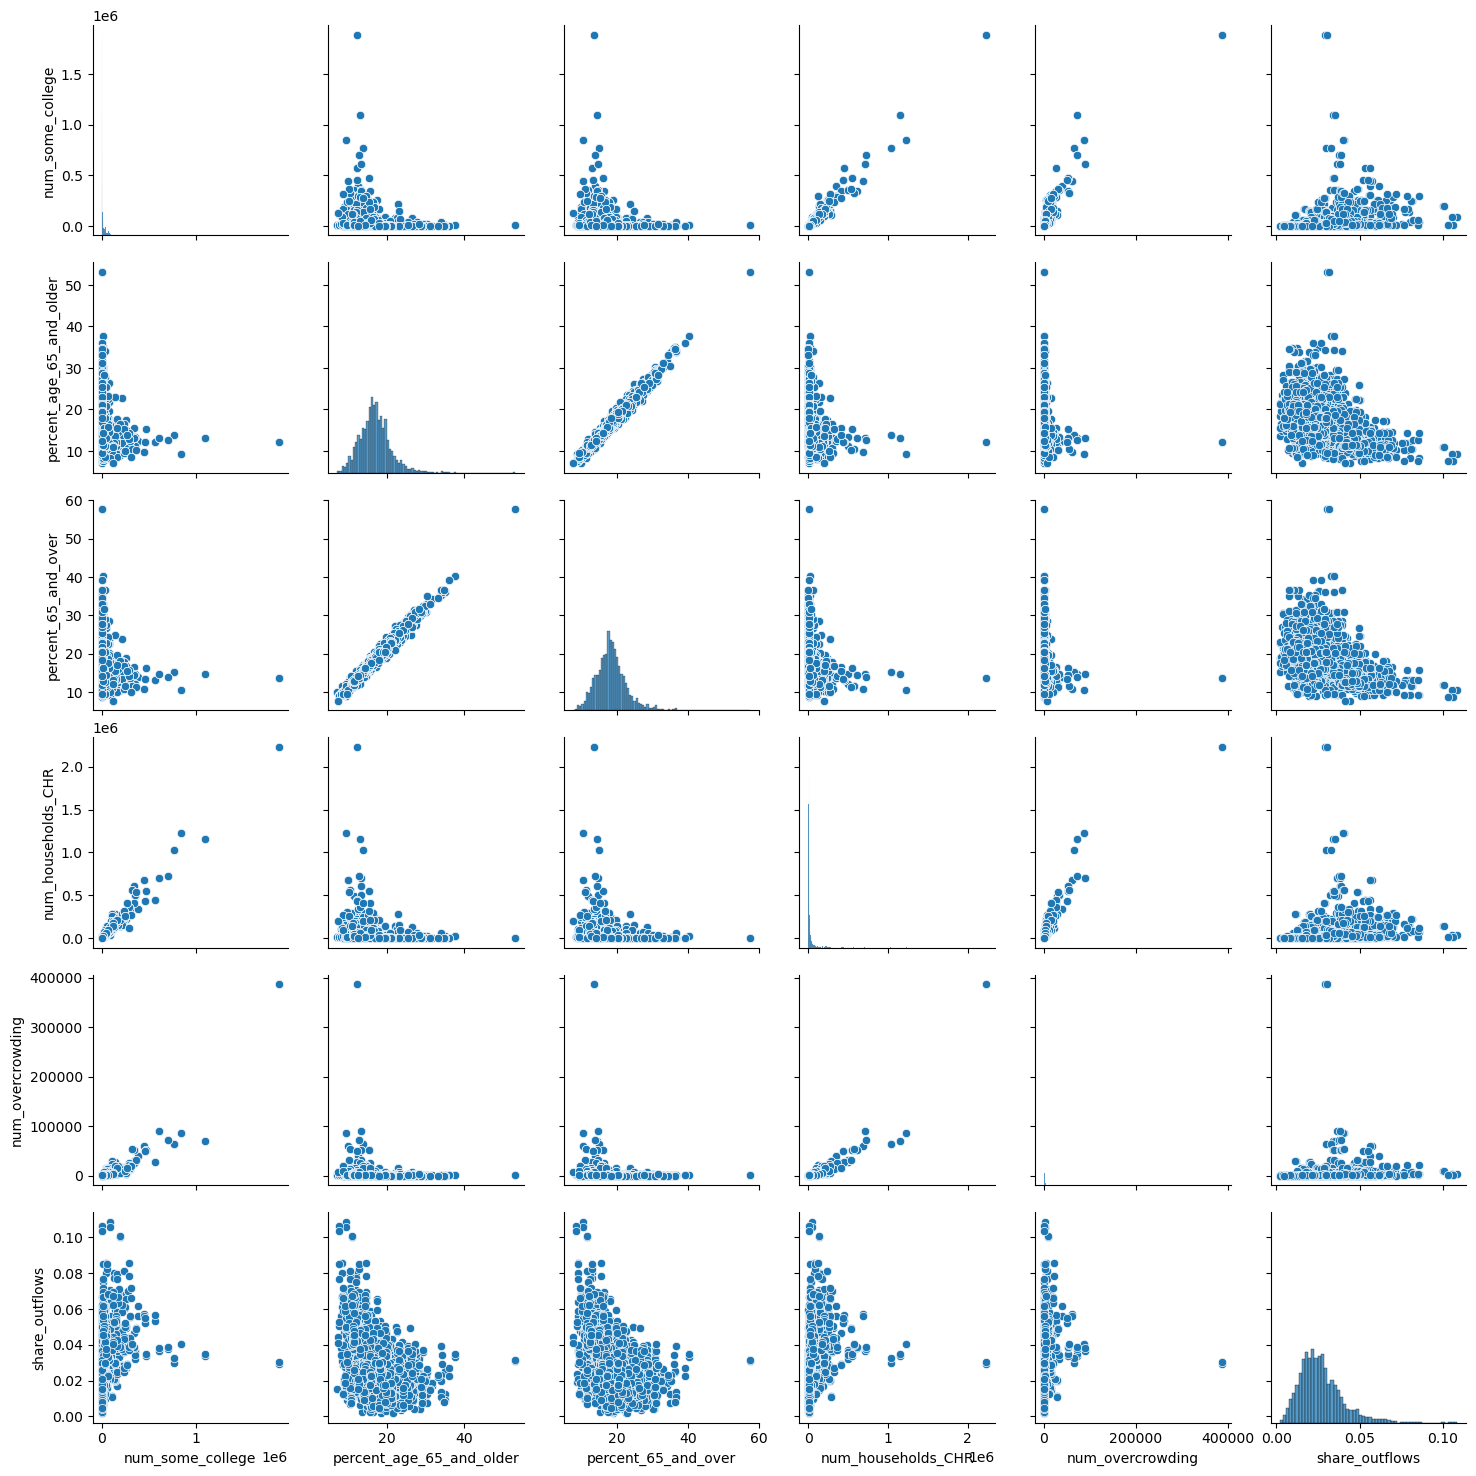

In [25]:
warnings.filterwarnings('ignore')
# Create a DataFrame with the top 5 predictors and the target variable
plot_data = X[top_5_predictors]
plot_data['share_outflows'] = Y

# Now create the pairplot
sns.pairplot(plot_data)
plt.show()

In our analysis, we used two different models to understand out migration from a county. Our first model was a baseline regression model that incorporated all variables — a 'kitchen sink' approach and second one was a LASSO regression. Both models demonstrated strong performances, as seen by their very low training MSE, suggesting an excellent fit to the training data. Moreover, the models also shows signs of generalisation, as indicated by the low and only slightly higher test MSE compared to the training MSE. In fact the train and test mse for lasso was higher or equal to the kitchen sink, which shows that surprisingly the kitchen sink outperformed lasso. Both had similar performance in terms of R2 though again kitchen sink outperformed with a higher value.

We also looked at top 5 feautres by absolute values of coeffecients in Lasso in the pairwise plot with share_outflows. Overall, these plots suggested that share_outflows does not have a strong linear correlation with the variables presented in the pairwise plots. The relationships, if they exist, may be more complex or possibly moderated by other factors not directly visible in these bivariate plots. 


In [26]:
#Bring together results so far
mse_regs = pd.DataFrame({
    'model': ['Lasso', 'Kitchen Sink Regression'],
    'train_mse': [train_mse_lasso, mse_train_reg],
    'test_mse': [test_mse_lasso, mse_test_reg],
    'r2':[r2_lasso, r2_reg]
})

mse_regs


,model,train_mse,test_mse,r2
0,Lasso,0.000047,0.000057,0.667252
1,Kitchen Sink Regression,0.000045,0.000057,0.668169


### Model 3: Simple Decision Tree

In this model, we will get the best max_depth using CV for Decision Tree Regressor.

In [27]:
# Separate features and target variable
X = df_base.drop(['share_outflows'], axis=1)  
Y = df_base['share_outflows']

# Split the dataset into the Training set and Test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [28]:
# Lists to store the mean squared errors for each value of max_depth
train_mse_list = []
test_mse_list = []
max_depth_values = list(range(1, 20))

# Loop over each max_depth, train a new model, and calculate MSE on train and test sets
for depth in max_depth_values:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(X_train, Y_train)
    
    # Predict and calculate MSE on the training set
    train_pred = model.predict(X_train)
    train_mse = mean_squared_error(Y_train, train_pred)
    train_mse_list.append(train_mse)
    
    # Predict and calculate MSE on the test set
    test_pred = model.predict(X_test)
    test_mse = mean_squared_error(Y_test, test_pred)
    test_mse_list.append(test_mse)


In [29]:
#Get best max depth
min_mse_index = test_mse_list.index(min(test_mse_list))
# Find the corresponding max_depth value
best_max_depth = list(max_depth_values)[min_mse_index]



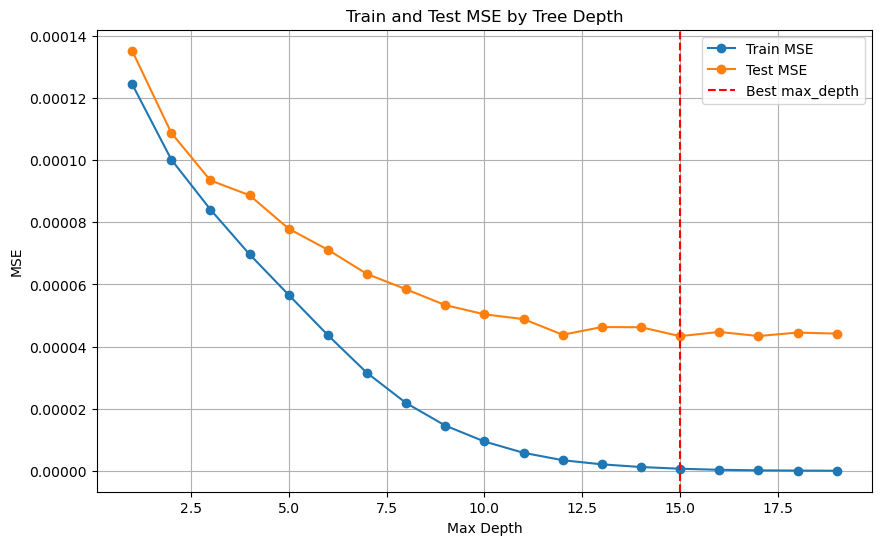

In [30]:
# Plotting the train and test MSEs for each max_depth
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_mse_list, label='Train MSE', marker='o')
plt.plot(max_depth_values, test_mse_list, label='Test MSE', marker='o')

# Highlight the best max_depth value
plt.axvline(x=best_max_depth, label='Best max_depth', color='red', linestyle='--')

plt.title('Train and Test MSE by Tree Depth')
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()


The optimal depth, 15, is where the test MSE is minimized, balancing the bias-variance tradeoff effectively. As Max depth increases, both the train and the test MSE tend to fall but plateau eventually.

In [31]:
# Train the model with the best_max_depth and get train_mse_dtree and test_mse_dtree
best_dtree_model = DecisionTreeRegressor(max_depth=best_max_depth, random_state=42)
best_dtree_model.fit(X_train, Y_train)

# Predict and calculate MSE on the training and test sets
train_pred_dtree = best_dtree_model.predict(X_train)
test_pred_dtree = best_dtree_model.predict(X_test)

train_mse_dtree = mean_squared_error(Y_train, train_pred_dtree)
test_mse_dtree = mean_squared_error(Y_test, test_pred_dtree)

r2_dtree = r2_score(Y_test, test_pred_dtree)


In [32]:
print("Best max_depth:", best_max_depth)
print("Train MSE for Decision Tree:", train_mse_dtree)
print("Test MSE for Decision Tree:", test_mse_dtree)
print(f"R2 for Decision Tree Regresion: {r2_dtree}")

Best max_depth: 15
Train MSE for Decision Tree: 6.658045851767741e-07
Test MSE for Decision Tree: 4.334196312599074e-05
R2 for Decision Tree Regresion: 0.7473366643333149


The Decision Tree model shows signs of overfitting, as evidenced by the large discrepancy between the Train MSE and Test MSE. While it learns the training data very well, it does not perform as strongly on the test data. The depth of the tree (15) might be a contributing factor to the overfitting, as deeper trees can capture more complex patterns but at the risk of learning noise from the training data. The R2 value indicates a relatively good fit of the model to the dataset, but this should be considered in light of the overfitting indicated by the MSE values.

### Model 4: Bagging

We will now use cross-validation to find best number of boostraps for bagging

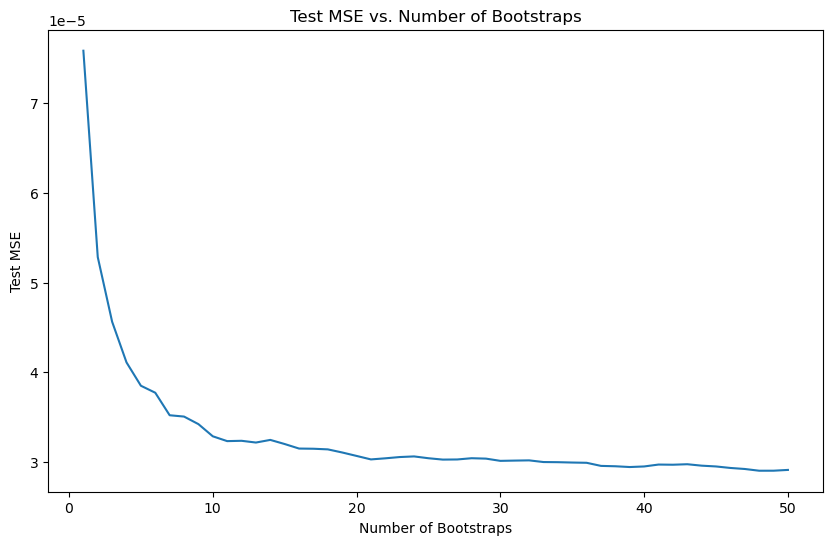

In [33]:
bootstrap_values = range(1, 51) 
test_mse_values = []

for num_bootstraps in bootstrap_values:
    # Define the Bagging Regressor Model
    bag_model = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=best_max_depth),
                                    n_estimators=num_bootstraps,
                                    max_samples=0.8,
                                    random_state=42)
    
    # Fit the model on the train data
    bag_model.fit(X_train, Y_train)
    
    # Predict on the test data and calculate MSE
    test_pred = bag_model.predict(X_test)
    mse = mean_squared_error(Y_test, test_pred)
    test_mse_values.append(mse)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(bootstrap_values, test_mse_values)
plt.title('Test MSE vs. Number of Bootstraps')
plt.xlabel('Number of Bootstraps')
plt.ylabel('Test MSE')
plt.show()


The observed graph provides valuable insights into the performance of our bagging model, particularly in relation to the impact of varying the number of bootstrapped datasets. We observe a decrease in the Test MSE as the number of bootstraps increases, indicating an enhancement in the model's predictive accuracy. This trend is consistent with the expected behavior of bagging models, where an ensemble of models, each trained on a different bootstrap sample, typically improves overall accuracy.

However, a key observation is that the Test MSE stabilizes and reaches a plateau after the inclusion of 20 bootstrap samples. This suggests that beyond this point, adding more bootstrapped models does not contribute significantly to further accuracy gains. This plateau indicates an optimal balance between the number of models in the ensemble and their collective predictive performance, highlighting the point of diminishing returns in terms of accuracy improvement.

In [34]:
bootstrap_mse_dict = dict(zip(bootstrap_values, test_mse_values))

# Find the bootstrap value associated with the minimum test MSE
min_mse = min(test_mse_values)  
best_bootstrap = bootstrap_values[test_mse_values.index(min_mse)]


In [35]:
# Define the Bagging Regressor Model
best_bagged_model = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=best_max_depth),
                                n_estimators=best_bootstrap,
                                max_samples=0.8,
                                random_state=42)                        

# Fit the model on the train data
best_bagged_model.fit(X_train, Y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=15), max_samples=0.8,
                 n_estimators=48, random_state=42)

In [36]:
train_pred_bag = best_bagged_model.predict(X_train)
test_pred_bag = best_bagged_model.predict(X_test)


train_mse_bag = mean_squared_error(Y_train, train_pred_bag)
test_mse_bag = mean_squared_error(Y_test, test_pred_bag)
r2_bag = r2_score(Y_test, test_pred_bag)

print("The train MSE of the Bagging model is", train_mse_bag)
print("The test MSE of the Bagging model is", test_mse_bag)
print("The R2 of the Bagging model is ", r2_bag)     


The train MSE of the Bagging model is 6.5344267323207075e-06
The test MSE of the Bagging model is 2.9041154761632443e-05
The R2 of the Bagging model is  0.8307036759650983


The Bagging model demonstrates a high level of accuracy on the training data, as seen by the very low Train MSE. The model also performs well on the test data, but not quite as well as on the training data. The slight difference in performance suggests a small degree of overfitting but is not a significant concern given the low magnitude of the Test MSE. The R2 value is quite high, indicating that the model does a good job of explaining the variance in the response variable, that is net migration.

### Model 5: Boosting

We will first use CV to find best learning rate for Boosting model 

In [37]:
# Initialize Gradient Boosting Regressor
boosted_model = GradientBoostingRegressor(n_estimators=best_bootstrap, max_depth=best_max_depth)

# Range of learning rates to test
learning_rates = learning_rates = [0.01, 0.05, 0.1]

# Set up GridSearchCV to find the best learning rate
param_grid = {'learning_rate': learning_rates}
grid_search = GridSearchCV(boosted_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, Y_train)

# Get the best learning rate and retrain the model
best_learning_rate = grid_search.best_params_['learning_rate']
best_model = GradientBoostingRegressor(n_estimators=best_bootstrap, max_depth=best_max_depth, learning_rate=best_learning_rate)
best_model.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=15, n_estimators=48)

In [38]:
# Predict on the test data
train_pred_boost = best_model.predict(X_train)
test_pred_boost = best_model.predict(X_test)

# Calculate the MSE
train_mse_boost = mean_squared_error(Y_train, train_pred_boost)
test_mse_boost = mean_squared_error(Y_test, test_pred_boost)
r2_boost = r2_score(Y_test, test_pred_boost)

print("Best Learning Rate:", best_learning_rate)
print("Train MSE of the Boosting model:", train_mse_boost)
print("Test MSE of the Boosting model:", test_mse_boost)
print("The R2 of the Boosting model is ", r2_boost)     


Best Learning Rate: 0.05
Train MSE of the Boosting model: 1.224252762471371e-06
Test MSE of the Boosting model: 3.8138274392609714e-05
The R2 of the Boosting model is  0.7776717312827575


The chosen Gradient Boosting model, with its learning rate, number of estimators, and max depth, performs exceptionally well on the training data, as shown by the very low Train MSE. The model also performs well on the test data. Although there's a discrepancy between Train and Test MSE, both values are quite low, suggesting good predictive accuracy. The best learning rate of 0.05 indicates that the model benefits from a moderate pace of learning, balancing the bias-variance tradeoff effectively.
The higher Test MSE relative to Train MSE suggests some overfitting. However, given the low absolute value of the Test MSE, the model appears to generalize well to unseen data.

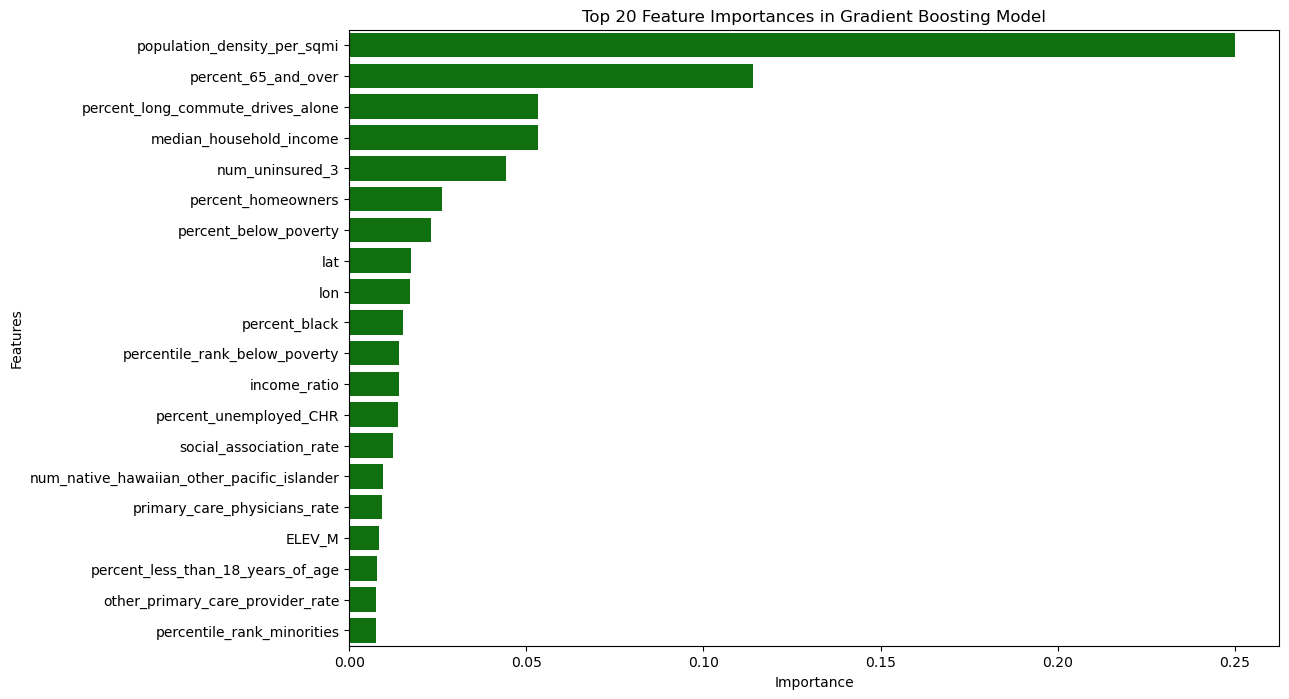

In [39]:
# Find the most important features
feature_imp = best_model.feature_importances_
feature_names = X_train.columns

# Create a series for the feature importances with the feature names as the index
imp = pd.Series(feature_imp, index=feature_names)

# Sort features by importance and select the top 20
sorted_imp = imp.sort_values(ascending=False)[:20]

imp_df = sorted_imp.reset_index()
imp_df.columns = ['Feature', 'Importance']

# Plot the feature importances horizontally using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=imp_df, color='green')

plt.title('Top 20 Feature Importances in Gradient Boosting Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

Population Density per sqaure miles is a highly ranked feature. This means that the model relies on it the most to make predictions for the response variable net outflows. However, this variable is important for predictions may not be underlying reason why individuals might be migrating out of a county.

### Model 6: Random Forest

In [40]:
# #The below grid search takes some time to run so we will comment it out and use the best n_estimators and max_depth we get from here (results shown below) and run model based on the parameters we got

# # Parameters to search
# param_grid = {
#     'n_estimators': [50, 100, 500], 
#     'max_depth': [None, 5, 10, 20]}

# # Base model
# rf = RandomForestRegressor(random_state=42)

# # Initialize grid search 
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# # Fit to data
# grid_search.fit(X_train, Y_train)

# # Best parameters
# best_params = grid_search.best_params_
# print("Best parameters:", best_params)

# # Train the model using best parameters found
# best_rf = RandomForestRegressor(**best_params, random_state=42)
# best_rf.fit(X_train, Y_train)

# # Predict on train and test data
# train_pred_rf = best_rf.predict(X_train)
# test_pred_rf = best_rf.predict(X_test)

# # Calculate MSE and R2 
# train_mse_rf = mean_squared_error(Y_train, train_pred_rf)
# test_mse_rf = mean_squared_error(Y_test, test_pred_rf)
# r2_rf = r2_score(Y_test, test_pred_rf)

# print("Train MSE of the Random Forest model:", train_mse_rf)
# print("Test MSE of the Random Forest model:", test_mse_rf)
# print("R2 of the Random Forest model:", r2_rf)

## RESULTS FROM RUNNING THIS BLOCK
## Best parameters: {'max_depth': 20, 'n_estimators': 500}
## Train MSE of the Random Forest model: 3.3680375002925824e-06
## Test MSE of the Random Forest model: 2.5074378764588213e-05
## R2 of the Random Forest model: 0.8538281212594259


In [41]:
# Create a Random Forest Regressor with parameters from hyper-tuning above
best_rf_model = RandomForestRegressor(n_estimators=500, max_depth=20, random_state=42)

# Train the model on the training data
best_rf_model.fit(X_train, Y_train)


RandomForestRegressor(max_depth=20, n_estimators=500, random_state=42)

In [42]:
# Predict on the train and test data to calculate MSE
train_pred_rf = best_rf_model.predict(X_train)
test_pred_rf = best_rf_model.predict(X_test)

train_mse_rf = mean_squared_error(Y_train, train_pred_rf)
test_mse_rf = mean_squared_error(Y_test, test_pred_rf)

r2_rf = r2_score(Y_test, test_pred_rf)

print("The MSE of the Random Forest model is", train_mse_rf)
print("The MSE of the Random Forest model is", test_mse_rf)
print("The R2 of the Random Forest model is ", r2_rf)  

The MSE of the Random Forest model is 3.3680375002925824e-06
The MSE of the Random Forest model is 2.5074378764588213e-05
The R2 of the Random Forest model is  0.8538281212594259


These numbers suggest the model is highly predictive, with an R² score indicating that approximately 85.38% of the variance in the target variable is explained by the model. The low MSE values indicate that the model's predictions are close to the actual values, with the model performing slightly better on the training data than on the test data, which is expected. However, the difference in MSE between training and testing is not substantial, which is a good sign of the model not being overfitted to the training data.

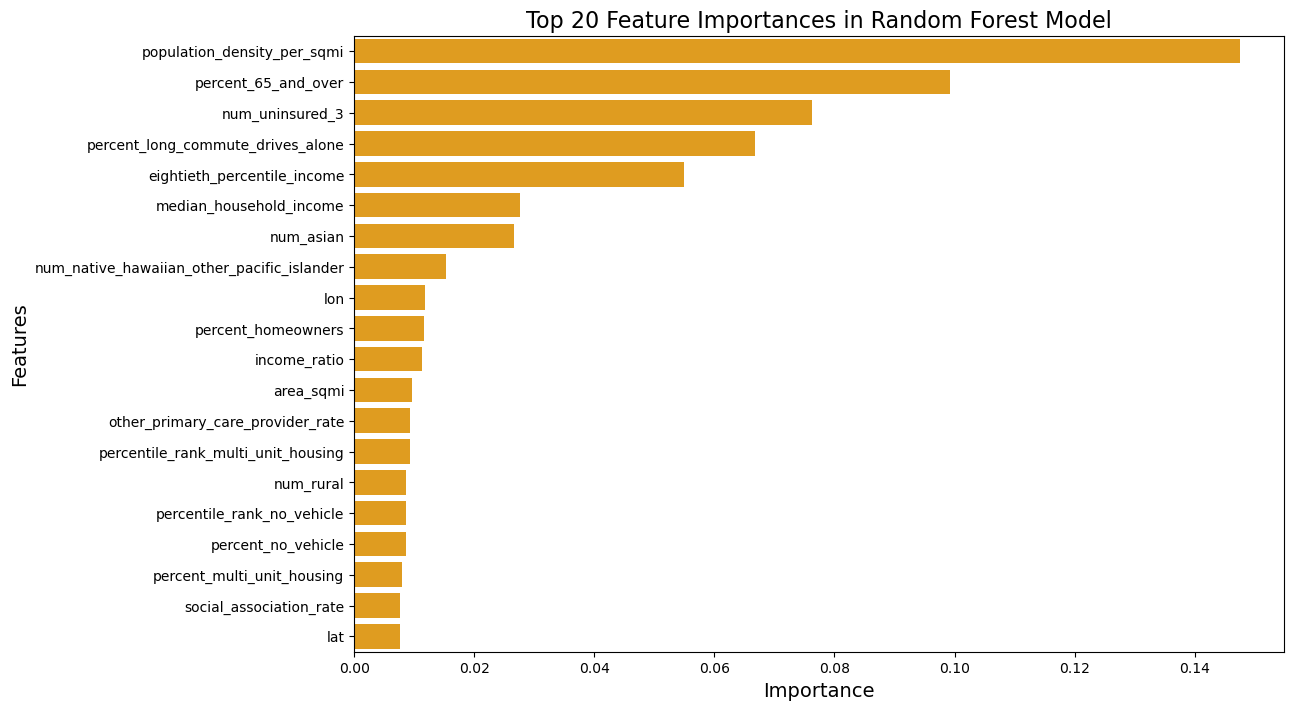

In [43]:
#Feature importance for random forest model
feature_imp = best_rf_model.feature_importances_
feature_names = X_train.columns

# Sort features
imp = pd.Series(feature_imp, index=feature_names)
sorted_imp = imp.sort_values(ascending=False)[:20]
imp_df = sorted_imp.reset_index()
imp_df.columns = ['Feature', 'Importance']

# Creating the horizontal bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=imp_df, color='orange')

# Setting the title and labels
plt.title('Top 20 Feature Importances in Random Forest Model', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show()


From the visual, we can make the following interpretations:

- Population Density: The feature population_density_per_sqmi is the most important feature according to the model. This suggests that areas with different population densities significantly affect the target variable, which could be related to outflows, as you've mentioned before.

- Demographic Features: Features like percent_65_and_over, num_uninsured, and demographic counts like num_asian and num_native_hawaiian_other_pacific_islander are important predictors. This indicates that the age distribution of the population, health insurance coverage, and racial composition have a notable impact on the model's predictions.

- Income Metrics: Several features related to income, such as eighthieth_percentile_income and median_household_income, are important, implying that the financial well-being of a region's residents is a strong predictor.

- Geographical Features: Longitude (lon) and latitude (lat) are also in the top 20 features, which means that geographical location plays a role in the prediction.

- Housing and Transportation: Housing characteristics (percentile_rank_multi_unit_housing, percent_no_vehicle, percent_multi_unit_housing) and transportation (percent_long_commute_drives_alone) are also significant, suggesting an influence of local infrastructure and living conditions on the target variable.

The bar chart shows that the model finds a diverse set of features to be of varying importance. No single feature overwhelmingly dominates, which indicates that the model is using a wide array of data to inform its predictions.

<h2 style="color: black;"> Model Comparisons </h2> 


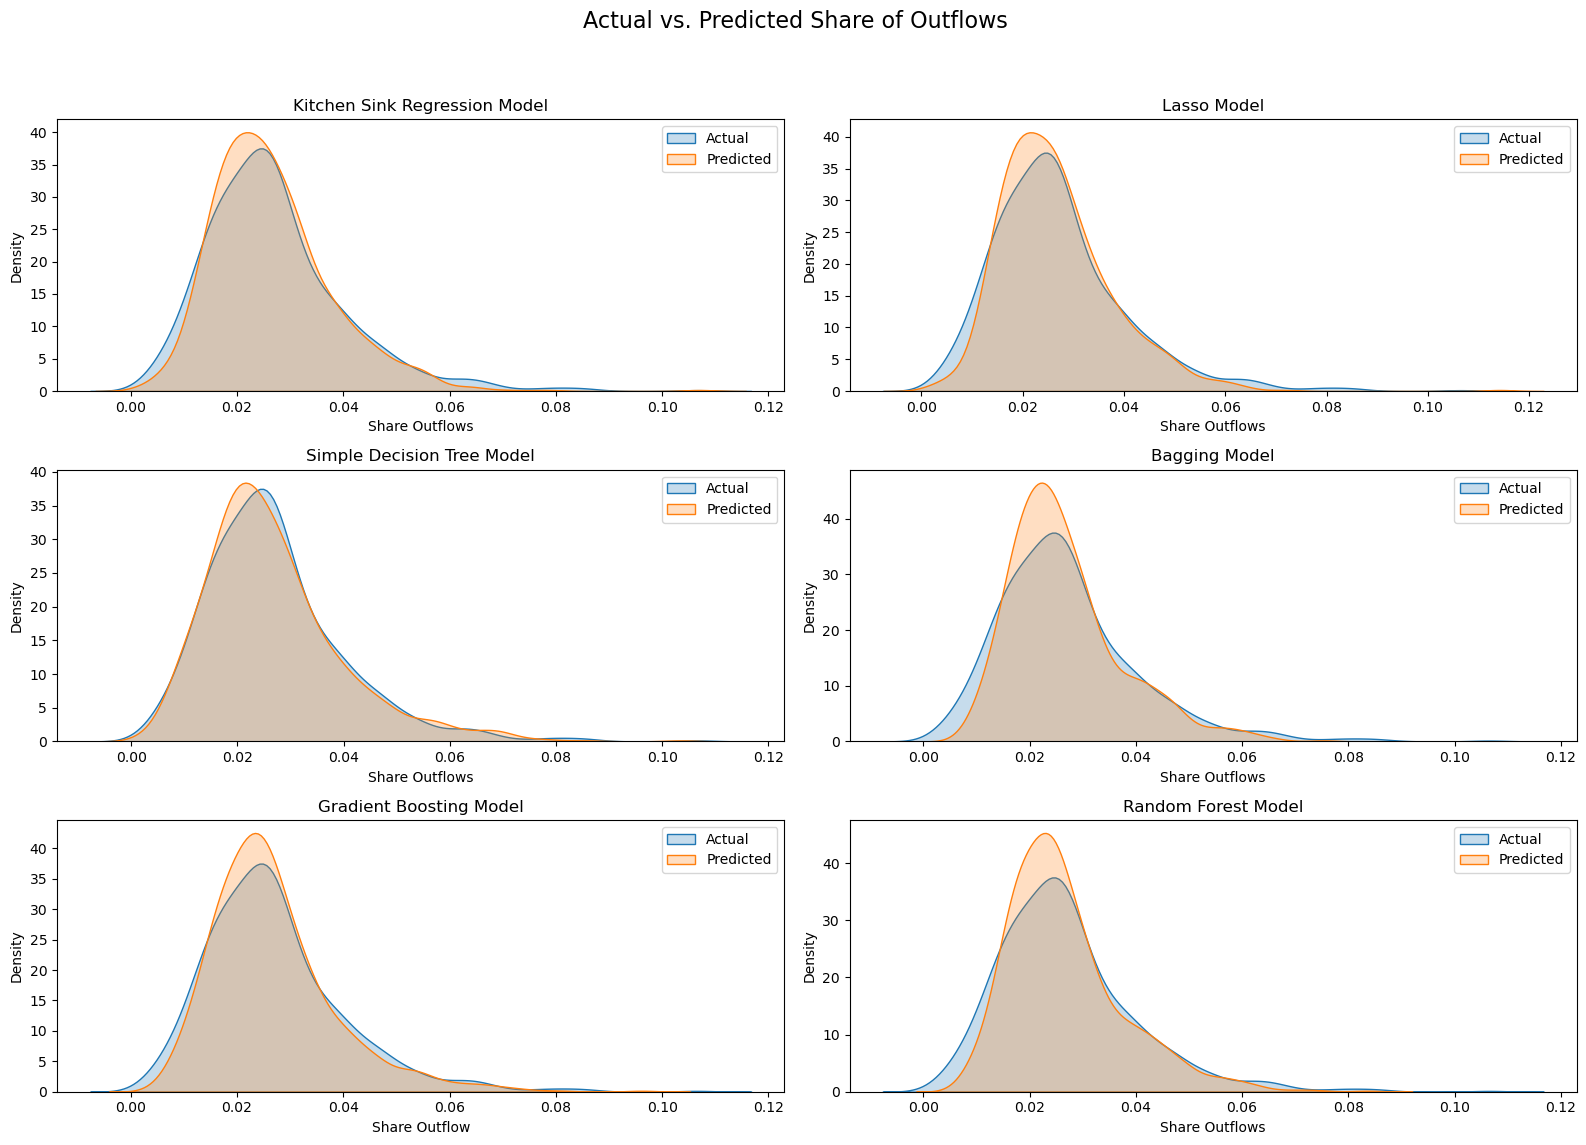

In [44]:
#Check how distributions of actual and predicted values look for each model

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
warnings.filterwarnings('ignore')

# Kitchen Sink Regression Model
sns.kdeplot(Y_test, label='Actual', fill=True, ax=axs[0, 0])
sns.kdeplot(test_pred_reg, label='Predicted', fill=True, ax=axs[0, 0])
axs[0, 0].set_title('Kitchen Sink Regression Model')
axs[0, 0].set_xlabel('Share Outflows')
axs[0, 0].set_ylabel('Density')
axs[0, 0].legend()

# Lasso Model
sns.kdeplot(Y_test, label='Actual', fill=True, ax=axs[0, 1])
sns.kdeplot(test_pred_lasso, label='Predicted', fill=True, ax=axs[0, 1])
axs[0, 1].set_title('Lasso Model')
axs[0, 1].set_xlabel('Share Outflows')
axs[0, 1].set_ylabel('Density')
axs[0, 1].legend()

# Simple Decision Tree Model
sns.kdeplot(Y_test, label='Actual', fill=True, ax=axs[1, 0])
sns.kdeplot(test_pred_dtree, label='Predicted', fill=True, ax=axs[1, 0])
axs[1, 0].set_title('Simple Decision Tree Model')
axs[1, 0].set_xlabel('Share Outflows')
axs[1, 0].set_ylabel('Density')
axs[1, 0].legend()

# Bagging Model
sns.kdeplot(Y_test, label='Actual', fill=True, ax=axs[1, 1])
sns.kdeplot(test_pred_bag, label='Predicted', fill=True, ax=axs[1, 1])
axs[1, 1].set_title('Bagging Model')
axs[1, 1].set_xlabel('Share Outflows')
axs[1, 1].set_ylabel('Density')
axs[1, 1].legend()

# Gradient Boosting Model
sns.kdeplot(Y_test, label='Actual', fill=True, ax=axs[2, 0])
sns.kdeplot(test_pred_boost, label='Predicted', fill=True, ax=axs[2, 0])
axs[2, 0].set_title('Gradient Boosting Model')
axs[2, 0].set_xlabel('Share Outflow')
axs[2, 0].set_ylabel('Density')
axs[2, 0].legend()

# Random Forest Model
sns.kdeplot(Y_test, label='Actual', fill=True, ax=axs[2, 1])
sns.kdeplot(test_pred_rf, label='Predicted', fill=True, ax=axs[2, 1])
axs[2, 1].set_title('Random Forest Model')
axs[2, 1].set_xlabel('Share Outflows')
axs[2, 1].set_ylabel('Density')
axs[2, 1].legend()

# Set a common title for the figure
fig.suptitle('Actual vs. Predicted Share of Outflows', fontsize=16)

# Adjust layout and display the plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


The density plots show how closely the predicted values (orange line) align with the actual values (blue area). An ideal model would have the predicted line directly on top of the actual distribution, indicating perfect predictions.
The closer the two distributions are, the better the model's predictions match the actual data. In all plots, the predicted distributions seem to follow the actual distributions reasonably closely, indicating that the models have predictive power.


In [45]:
# calculate residuals for each model
residuals_reg = Y_test - test_pred_reg
residuals_lasso = Y_test - test_pred_lasso
residuals_dtree = Y_test - test_pred_dtree
residuals_bag = Y_test - test_pred_bag
residuals_boost = Y_test - test_pred_boost
residuals_rf = Y_test - test_pred_rf

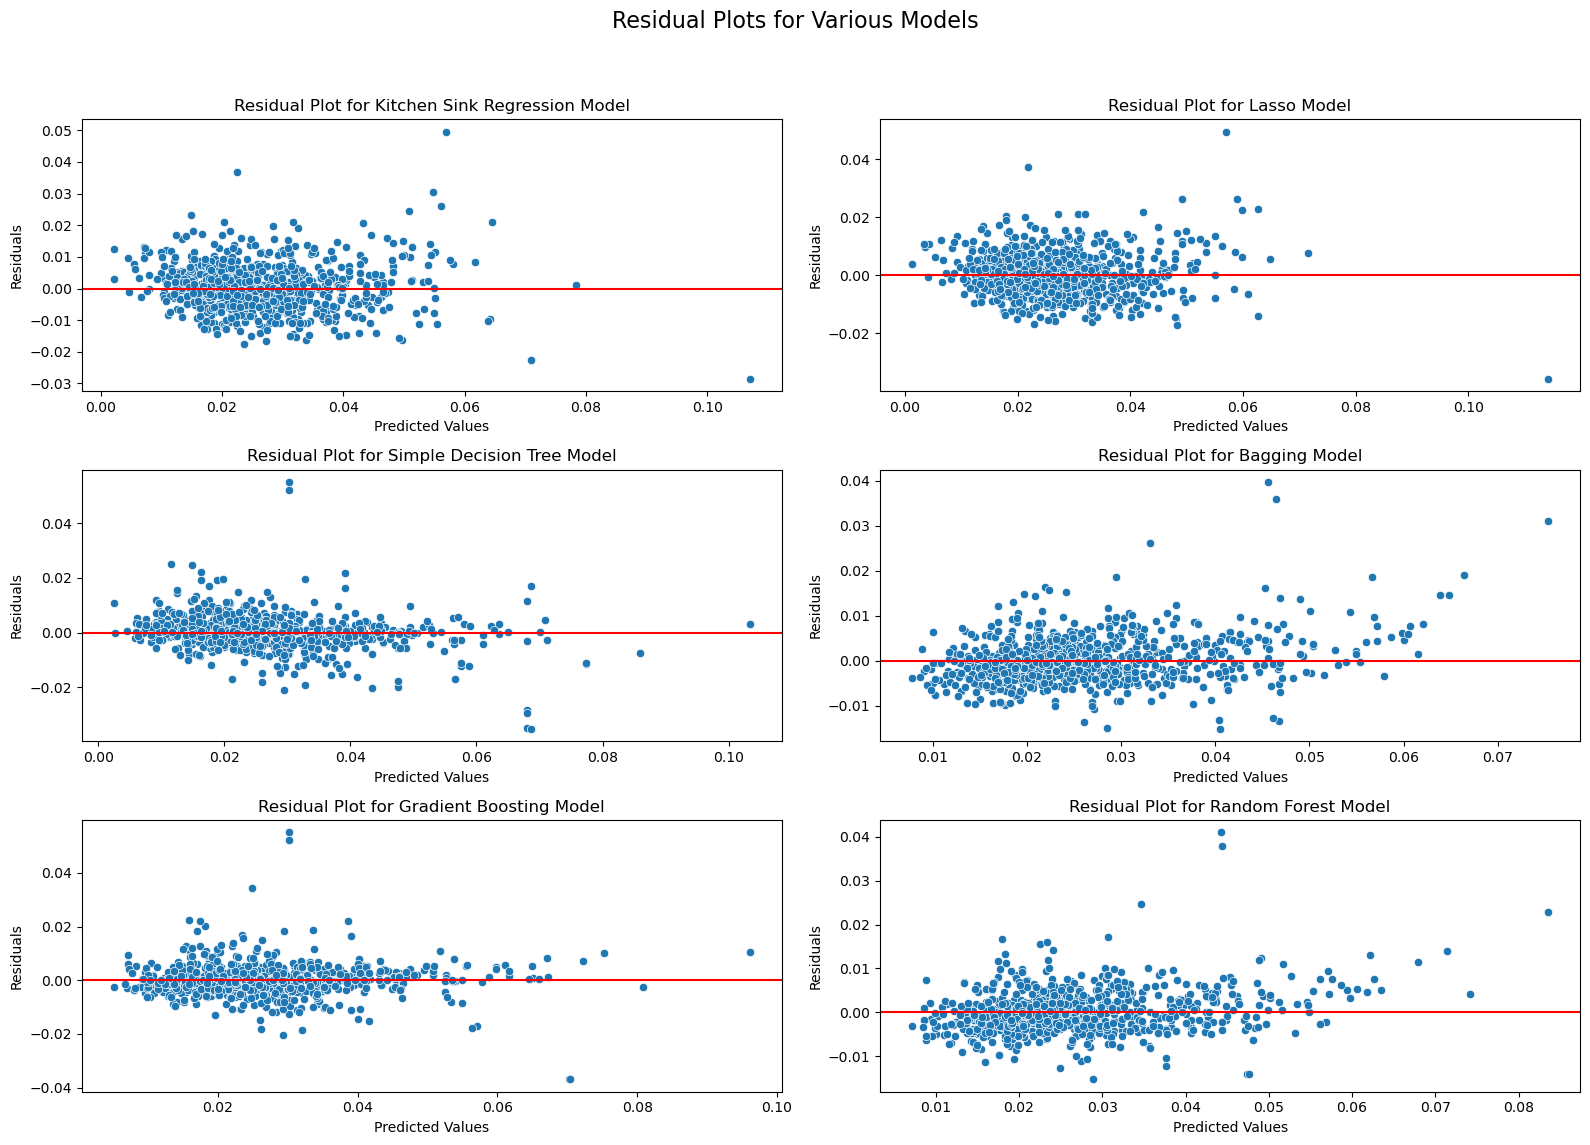

In [46]:
# create a residual plot for each model 
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
warnings.filterwarnings('ignore')

# Kitchen Sink Regression Model
sns.scatterplot(x=test_pred_reg, y=residuals_reg, ax=axs[0, 0])
axs[0, 0].axhline(y=0, color='r', linestyle='-')
axs[0, 0].set_title('Residual Plot for Kitchen Sink Regression Model')
axs[0, 0].set_xlabel('Predicted Values')
axs[0, 0].set_ylabel('Residuals')

# Lasso Model
sns.scatterplot(x=test_pred_lasso, y=residuals_lasso, ax=axs[0, 1])
axs[0, 1].axhline(y=0, color='r', linestyle='-')
axs[0, 1].set_title('Residual Plot for Lasso Model')
axs[0, 1].set_xlabel('Predicted Values')
axs[0, 1].set_ylabel('Residuals')

# Simple Decision Tree Model
sns.scatterplot(x=test_pred_dtree, y=residuals_dtree, ax=axs[1, 0])
axs[1, 0].axhline(y=0, color='r', linestyle='-')
axs[1, 0].set_title('Residual Plot for Simple Decision Tree Model')
axs[1, 0].set_xlabel('Predicted Values')
axs[1, 0].set_ylabel('Residuals')

# Bagging Model
sns.scatterplot(x=test_pred_bag, y=residuals_bag, ax=axs[1, 1])
axs[1, 1].axhline(y=0, color='r', linestyle='-')
axs[1, 1].set_title('Residual Plot for Bagging Model')
axs[1, 1].set_xlabel('Predicted Values')
axs[1, 1].set_ylabel('Residuals')

# Gradient Boosting Model
sns.scatterplot(x=test_pred_boost, y=residuals_boost, ax=axs[2, 0])
axs[2, 0].axhline(y=0, color='r', linestyle='-')
axs[2, 0].set_title('Residual Plot for Gradient Boosting Model')
axs[2, 0].set_xlabel('Predicted Values')
axs[2, 0].set_ylabel('Residuals')

# Random Forest Model
sns.scatterplot(x=test_pred_rf, y=residuals_rf, ax=axs[2, 1])
axs[2, 1].axhline(y=0, color='r', linestyle='-')
axs[2, 1].set_title('Residual Plot for Random Forest Model')
axs[2, 1].set_xlabel('Predicted Values')
axs[2, 1].set_ylabel('Residuals')

# Set a common title for the figure
fig.suptitle('Residual Plots for Various Models', fontsize=16)

# Adjust layout and display the plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Ideally, residuals should be randomly distributed and centered around the horizontal axis (residuals = 0, marked with the red line). This would indicate that the model's predictions are unbiased. If the residuals show a pattern (like a clear curve or trend), this indicates model bias or that the model is missing some explanatory information.

- Kitchen Sink Regression Model: The residuals appear to be randomly scattered around the horizontal axis, but there is some noticeable spread as the predicted values increase. This indicates that the model may be less accurate at higher values of the target variable.

- Lasso Model: The residuals are more tightly clustered around the horizontal line, which is a good sign. However, there are a few outliers which might affect the model's overall performance.

- Simple Decision Tree Model: The plot shows a random scatter of residuals, but a slight funnel shape widens as predicted values increase, indicating potential heteroscedasticity (non-constant variance of residuals).

- Bagging Model: The residuals are spread out with no clear pattern, suggesting that the model predictions are unbiased. However, there are several outliers, and a slight funnel shape indicates that variance in the residuals increases with the predicted value.

- Gradient Boosting Model: The residuals are tightly clustered and seem to have a uniform spread across the range of predictions. This suggests good model performance with consistent error variance.

- Random Forest Model: Similar to the Gradient Boosting Model, the residuals are uniformly spread but show a slight indication of increased variance for higher predicted values.

In general, all models seem to perform reasonably well, with no clear pattern of residuals that would indicate bias. Some models, like the Gradient Boosting and Random Forest, appear to have better performance due to the more uniform spread of residuals, which suggests a consistent predictive performance across the range of predicted values. However, the slight funnel shapes in some plots imply that the variance of errors may be increasing with predicted values, which is a phenomenon known as heteroscedasticity. This could be improved potentially by transforming the target variable or applying variance-stabilizing techniques.

In [48]:
#Bring together prediction results from all models!
mse_df = pd.DataFrame({
    'model': ['Random Forest', 'Bagging', 'Boosting', 'Simple Decision Tree', 'Lasso', 'Kitchen Sink Regression'],
    'train_mse': [train_mse_rf, train_mse_bag, train_mse_boost, train_mse_dtree, train_mse_lasso, mse_train_reg],
    'test_mse': [test_mse_rf, test_mse_bag, test_mse_boost,  test_mse_dtree, test_mse_lasso, mse_test_reg],
    'r2':[r2_rf, r2_bag, r2_boost, r2_dtree, r2_lasso, r2_reg]
})

mse_df


,model,train_mse,test_mse,r2
0,Random Forest,3.368038e-06,0.000025,0.853828
1,Bagging,6.534427e-06,0.000029,0.830704
2,Boosting,1.224253e-06,0.000038,0.777672
3,Simple Decision Tree,6.658046e-07,0.000043,0.747337
4,Lasso,4.747376e-05,0.000057,0.667252
5,Kitchen Sink Regression,4.508344e-05,0.000057,0.668169


Based on Test MSE and R2, the Random Forest model performs the best, followed by Bagging, Boosting, Simple Decision Tree, and finally the linear models (Lasso and Kitchen Sink Regression). The Simple Decision Tree shows a significant discrepancy between Train and Test MSE, indicating overfitting. Lasso and Kitchen Sink Regression also show some overfitting but to a lesser extent. Random Forest, Boosting, and Bagging show better generalization abilities compared to the Simple Decision Tree and linear models. This highlights the effectiveness of ensemble methods in reducing overfitting and improving model performance on unseen data.

At the same time, these ensemble methods are also generally less interpretable due to their complexity. They make it difficult to trace back the specific reasons for individual predictions. However, to find the most important predictor, we have been able to visualise importance of various features in these models.

<a id='results'></a>
## Results

- Model performance: The Random Forest model has the lowest test MSE, suggesting it predicts the test data with the least error among the models. Its R2 score is also the highest, indicating it explains the most variance in the data. The Gradient Boosting Model has the lowest train MSE but a higher test MSE compared to the Random Forest model, which might suggest a bit of overfitting to the training data. The Bagging and Simple Decision Tree models also perform reasonably well but not as good as the Random Forest model. The Lasso and Kitchen Sink Regression models have higher MSEs and lower R2 scores, indicating they perform less well compared to the ensemble methods. As a caveat, the test MSE as you can note is extremely low. After checking for data leakages which was not the case, we think this could potentially be due to lack of variation in share of outflows data.


- Model Comparison: Ensemble methods (Random Forest, Boosting, and Bagging) generally outperform single-predictor models (Simple Decision Tree) and linear models (Lasso, Kitchen Sink Regression), as indicated by the lower MSEs and higher R2 scores. There's a trade-off between bias and variance among these models. The more complex models (like Random Forest and Gradient Boosting) have a lower bias but might suffer from higher variance, which could be an indicator of overfitting if the difference between train and test MSE is large.

- Goodness of Fit: The R2 values suggest that all models have some predictive power, but the ensemble models are better at capturing the variance in the data.
The Random Forest model seems to be the best fit, with the highest score and the lowest test MSE, suggesting it generalizes well to new data.
In summary, while all models show some capability to predict the share of outflows, the Random Forest model stands out as the most effective in terms of the balance between training performance and generalization to the test data. However, it's crucial to also consider the complexity of the model, the computation time, and the interpretability depending on the specific use case.



<a id='conclusion'></a>
## Conclusion and Scope for Improvement

_This predictive analysis can now be used for:_

 1. Creating effective, targeted economic and social policies in counties to support communities facing demographic changes
 2. Preparing education and healthcare systems for changing populations
 3. Influencing instrastructure development and environmental management strategies
 4. Understanding changes in employment opportunities, that influence both local businesses and job seekers

However, our work in the future can be expanded to include:

1. Recommendations for how our model can be implemented for better economic decision-making in areas that are predicted to have high out migration
2. Recommendations for how the model can be scaled to handle even more granular data (e.g. at the ZIP-code level)
3. Recommendations for how the model can be expanded to include data from more recent years such as 2022 or 2023 where the effects of the pandemic are less salient